In [15]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set(style="darkgrid")

In [16]:
data = pd.read_csv('./train_loan.csv')
d1 = data.copy()
d1.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [17]:
#Lets do some Exploratory Data Analysis
d1.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


<AxesSubplot:xlabel='Education', ylabel='ApplicantIncome'>

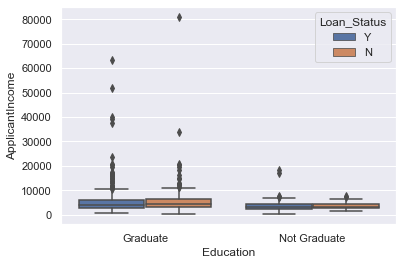

In [18]:
#Let's take a look at Education and income between approved and disapproved loans
sns.boxplot(x='Education',y='ApplicantIncome',data=d1,hue='Loan_Status')

In [19]:
#Seems income doesnt play a big factor

<AxesSubplot:xlabel='ApplicantIncome', ylabel='Education'>

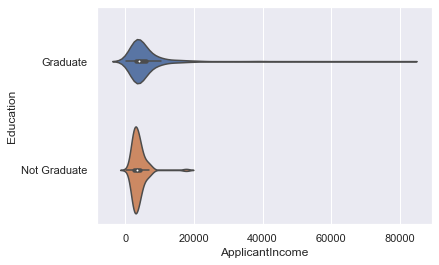

In [20]:
#Lets see in this dataset if education is correlated with Income
sns.violinplot(x='ApplicantIncome',y='Education',data=d1)

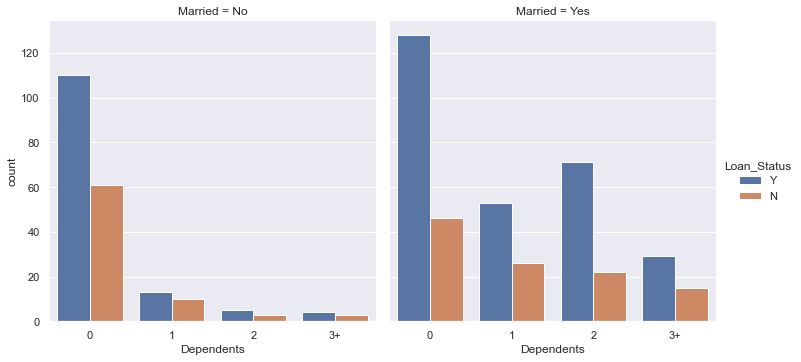

In [21]:
#Graduates have a broader distribution and higher mean income
#What about Married and number of dependents?
sns.catplot(hue='Loan_Status',x='Dependents',col='Married',data=d1,kind='count')

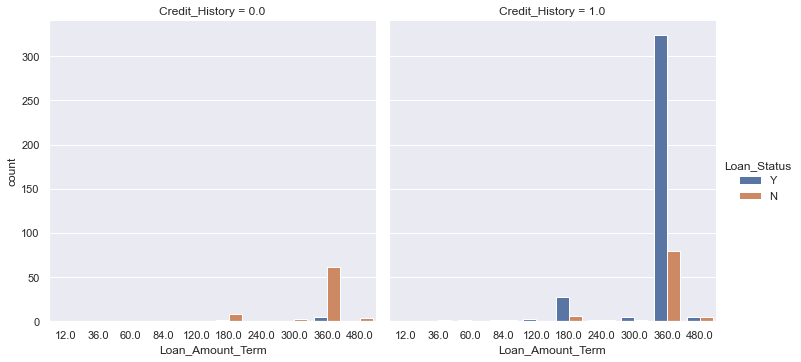

In [22]:
#Let's take a look at loan term and credit history
sns.catplot(hue='Loan_Status',x='Loan_Amount_Term',col='Credit_History',data=d1,kind='count')

In [23]:
#As we can see, credit history has a pretty big impact regardless of the term of the loan

In [25]:
#Feature Engineering (Categorize and convert types for all features)
X = data.copy()
X['Loan_Status'] = d1['Loan_Status'].map({'N': 0, 'Y': 1})
X['Self_Employed'] = d1['Self_Employed'].map({'No': 0, 'Yes': 1})
X['Education'] = d1['Education'].map({'Not Graduate': 0, 'Graduate': 1})
X['Married'] = d1['Married'].map({'No': 0, 'Yes': 1})
X['Gender'] = d1['Gender'].map({'Female': 0, 'Male': 1})
X = X.replace(to_replace={'Dependents': {'1': 1, '2': 2, '3+': 3}})
X['Dependents'] = X['Dependents'].astype('float64')
X = pd.get_dummies(X, columns=['Property_Area'])
X = X.drop(columns=['Loan_ID'])
for col in X.columns:
    X[col] = X[col].astype('float64')

In [26]:
#Now will use imputer to handle null values
y = X['Loan_Status']
X_no_loans = X.drop(columns=['Loan_Status'])
X_train, X_test, y_train, y_test = train_test_split(X_no_loans,y,test_size=0.1,random_state=0)

from sklearn.impute import SimpleImputer
imp = SimpleImputer()
X_train = imp.fit_transform(X_train)
X_test = imp.transform(X_test)


In [27]:
#As baseline, let us use median of loan_status
(abs(y_test - y_train.median())).sum()/len(y_test)

0.24193548387096775

In [28]:
from sklearn.naive_bayes import MultinomialNB
NBmodel = MultinomialNB()
NBmodel.fit(X_train, y_train)
labels = NBmodel.predict(X_test)

In [35]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, labels)

In [48]:
from sklearn.linear_model import LogisticRegression
logit_model = LogisticRegression(max_iter=1000)
logit_model.fit(X_train,y_train)
labels = logit_model.predict(X_test)

<AxesSubplot:>

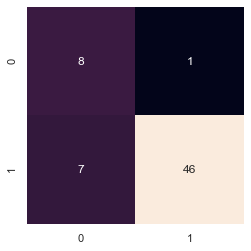

In [49]:
mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=[0,1], yticklabels=[0,1])

In [50]:
from sklearn.metrics import accuracy_score
accuracy_score(labels, y_test)

0.8709677419354839

In [59]:
#Now sophisticated xgboost
from xgboost import XGBClassifier
my_model = XGBClassifier(use_label_encoder=False,verbosity=0)
my_model.fit(X_train, y_train)

y_pred = my_model.predict(X_test)
accuracy_score(y_pred, y_test)

0.7903225806451613

In [43]:
#Seems linear regression fits better than xgboost at first glance!